# Machine Learning for Finance - Homework 2


In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import altair as alt

alt.data_transformers.disable_max_rows()

import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.cluster.hierarchy import fcluster
import scipy.linalg as la
from numpy.linalg import solve, norm
from statsmodels.stats.correlation_tools import cov_nearest

seed = 4

In [2]:
# define functions 

def log_return(df):
    """Given dataframe, return its first order log return"""
    return np.log(df).diff().drop(index=df.index[0], axis=0, inplace=False)


def na_fill(df):
    # Simulates `na.fill(as.xts(rowAvgs(df),order.by=index(df)),"extend")`
    return df.interpolate(method="linear").fillna(method="bfill")


def create_index(df):
    # the linear method already does ffill for the tail values
    return na_fill(df.mean(axis=1, skipna=False))

def is_pos_def(x, epsilon):
    return np.all(np.linalg.eigvals(x) > epsilon)

def cov2cor(df):
    # convert covariance matrix to correlation matrix by dividing by the outer product of the standard deviations
    # this is equivalent to multiplying by the inverse of the diagonal matrix of standard deviations
    ind = df.index
    col = df.columns
    sigma = np.sqrt(np.diag(df))
    return df.div(pd.DataFrame(np.outer(sigma, sigma), index=ind, columns=col))

def clusterplot(cov, ncluster=6):
    # plot the correlation matrix with a dendrogram correlation matrix of the clusters
    sns.set(style='white')
    sns_plot = sns.clustermap(cov2cor(cov), cmap='vlag_r', robust=True, method="complete", vmin=-1, vmax=1)
    plt.setp(sns_plot.ax_heatmap.yaxis.get_majorticklabels(), color='red')
    plt.setp(sns_plot.ax_heatmap.xaxis.get_majorticklabels(), color='red')
    plt.title("Correlation")

    Z = sns_plot.dendrogram_row.linkage
    clusters = list(fcluster(Z, ncluster, criterion='maxclust'))
    assign_cluster = dict((k, clusters[k]) for k in range(len(cov.columns)))
    assigned_idx = [assign_cluster[idx] for idx in sns_plot.dendrogram_row.reordered_ind]
    i = 0
    while i < len(assigned_idx):
        cluster = assigned_idx[i]
        counter = 0
        while i < len(assigned_idx) and assigned_idx[i] == cluster:
            counter += 1
            i += 1
        sns_plot.ax_heatmap.add_patch(plt.Rectangle(
            xy=(i-counter, i-counter),
            width=counter,
            height=counter,
            fill=None, color='black', lw=1.5
        ))
    plt.show()


# Function to calculate Robust (ellipsoid) Global Maximum Return Portfolio
def portfolioMaxReturnRobustEllipsoid(mu_hat, S, kappa=0.1):
    mu_hat = np.array(mu_hat)
    S12 = la.cholesky(S)  # S12.T @ S12 = Sigma
    w = cp.Variable(len(mu_hat))
    prob = cp.Problem(cp.Maximize(mu_hat @ w - kappa * cp.norm(S12 @ w, p=2)), constraints=[w >= 0, sum(w) == 1])
    result = prob.solve()
    return w.value

# Exercise 2
The stocks chosen for analysis were 'AAPL', 'ABBV', 'AMZN', 'DB', 'DIS', 'FB', 'GOOG', 'HAL', 'HSBC'.

The dataframe is from 2015-01-01 to 2016-12-31.

In [3]:
begin_date = "2015-01-01"  # "2015-01-01" # not including
end_date = "2016-12-31" #"2019-12-20" #"2017-12-31" # including

adjusted_data = pd.read_csv('rds_data/adjusted.csv')
BBr_data = pd.read_csv('rds_data/BBr.csv')
PNlog_data = pd.read_csv('rds_data/PNlog.csv')

In [4]:
# convert the 'Date' column to datetime
adjusted_data['Date'] = pd.to_datetime(adjusted_data['Date'])   
BBr_data['Date'] = pd.to_datetime(BBr_data['Date'])
PNlog_data['Date'] = pd.to_datetime(PNlog_data['Date'])

# set index to Date
adjusted_data.set_index('Date', inplace=True)
BBr_data.set_index('Date', inplace=True)
PNlog_data.set_index('Date', inplace=True)

# take only first 9 columns 
adjusted_data = adjusted_data.iloc[:, :9]
BBr_data = BBr_data.iloc[:, :9]
PNlog_data = PNlog_data.iloc[:, :9]

In [5]:
fama_lib = pd.read_csv("data/F-F_Research_Data_Factors_daily.CSV", skiprows=4, skipfooter=1, index_col=0, engine='python')
fama_lib.index = pd.to_datetime(fama_lib.index, format="%Y%m%d")
fama_lib = fama_lib.iloc[:, 0:3] # We only use the first 3 columns

Preprocess the data

In [6]:

stockPrices = adjusted_data.truncate(
    before=begin_date,
    after=end_date
)
X = log_return(stockPrices)
T, N = X.shape  # nrow and ncol

F_FamaFrench = fama_lib.loc[X.index]/100   # Fama-French factors
BBrMkt = create_index(BBr_data)/100  # BBr Market index
PNlogMkt = create_index(PNlog_data)  # PNlog Market index
SentIndx = PNlogMkt.loc[X.index]           # Sentiment index


# FamaFrench + Sent index
FFS = na_fill(pd.merge(
    fama_lib.loc[X.index], SentIndx.rename("SentIndx"),
    left_index=True, right_index=True
))


/var/folders/n4/wdz2gxc13wl6m46by5g242kh0000gn/T/ipykernel_3301/3988679768.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(method="linear").fillna(method="bfill")
/var/folders/n4/wdz2gxc13wl6m46by5g242kh0000gn/T/ipykernel_3301/3988679768.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(method="linear").fillna(method="bfill")
/var/folders/n4/wdz2gxc13wl6m46by5g242kh0000gn/T/ipykernel_3301/3988679768.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.interpolate(method="linear").fillna(method="bfill")


Train test split

In [7]:
# split data into training and test data
T_trn = round(0.5*T)
X_trn = X.iloc[0:T_trn, ]
X_tst = X.iloc[T_trn:T, ]
F_FamaFrench_trn = F_FamaFrench.iloc[0:T_trn, ]
F_FamaFrench_tst = F_FamaFrench.iloc[T_trn:T, ]
SentIndx_trn = SentIndx.iloc[0:T_trn,]
SentIndx_tst = SentIndx.iloc[T_trn:T,]
FFS_trn = FFS.iloc[0:T_trn,]
FFS_tst = FFS.iloc[T_trn:T,]

# EDA

In [55]:
# Normalize the prices (price today divided by price on the first recorded day)
normalized_prices = stockPrices / stockPrices.iloc[0]

# Melt the DataFrame for easier plotting with Altair
long_normalized_prices = normalized_prices.reset_index().melt(
    id_vars='Date',
    var_name='stock',
    value_name='normalized_price'
)

# Plot the normalized prices using Altair
chart = alt.Chart(long_normalized_prices).mark_line().encode(
    x=alt.X('yearmonthdate(Date):T', title='Date'),
    y=alt.Y('normalized_price:Q', title='Normalized Price'),
    color=alt.Color('stock:N', title='Stock')
).properties(
    width=800,
    height=400
)

# To display the chart in a Jupyter notebook or similar environment, just type 'chart'
chart

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [63]:
long_normalized_prices

,Date,stock,normalized_price
0,2015-01-02,AAPL,1.000000
1,2015-01-05,AAPL,0.971828
2,2015-01-06,AAPL,0.971920
3,2015-01-07,AAPL,0.985549
4,2015-01-08,AAPL,1.023416
...,...,...,...
4531,2016-12-23,HSBC,0.967894
4532,2016-12-27,HSBC,0.967894
4533,2016-12-28,HSBC,0.965466
4534,2016-12-29,HSBC,0.965466


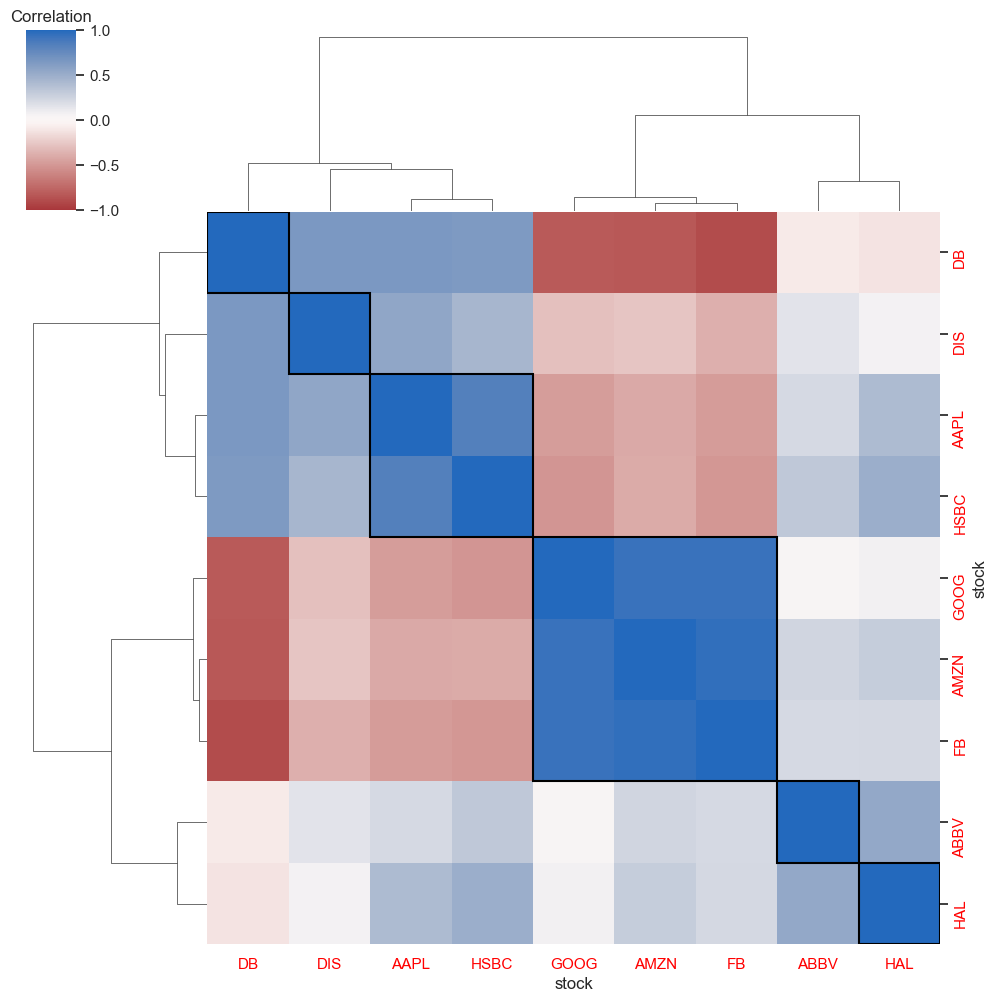

In [65]:
# Transform from long to wide format
wide_format = long_normalized_prices.pivot(index='Date', columns='stock', values='normalized_price')

# Calculate the covariance matrix
cov_matrix = wide_format.cov()

# Now use your clusterplot function
clusterplot(cov_matrix, ncluster=6)


#  Fama-French 3-factor model

In [8]:

F = F_FamaFrench_trn.copy()
F.insert(0, 'ones', 1)
Gamma = pd.DataFrame(solve(F.T @ F, F.T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta1", "beta2", "beta3"])
alpha = Gamma["alpha"]
B = Gamma[["beta1", "beta2", "beta3"]]
E = pd.DataFrame((X_trn.T - Gamma.to_numpy() @ F.to_numpy().T).T, index=X_trn.index)
PsiFF = (E.T @ E) / (T_trn - 4)
Sigma_FamaFrench = B.to_numpy() @ F_FamaFrench_trn.cov() @ B.to_numpy().T + np.diag(np.diag(PsiFF))

In [9]:
# add stock names to the columns and index 
Sigma_FamaFrench = pd.DataFrame(Sigma_FamaFrench)
Sigma_FamaFrench.columns = X_trn.columns
Sigma_FamaFrench.index = X_trn.columns
Sigma_FamaFrench

,AAPL,ABBV,AMZN,DB,DIS,FB,GOOG,HAL,HSBC
AAPL,0.000285,0.000122,0.000137,0.000138,0.000101,0.000126,0.000126,0.000126,0.000093
ABBV,0.000122,0.000411,0.000132,0.000133,0.000096,0.000128,0.000120,0.000108,0.000085
AMZN,0.000137,0.000132,0.000442,0.000138,0.000105,0.000138,0.000137,0.000115,0.000093
DB,0.000138,0.000133,0.000138,0.000404,0.000113,0.000130,0.000129,0.000171,0.000112
DIS,0.000101,0.000096,0.000105,0.000113,0.000208,0.000098,0.000098,0.000109,0.000076
FB,0.000126,0.000128,0.000138,0.000130,0.000098,0.000266,0.000126,0.000106,0.000086
GOOG,0.000126,0.000120,0.000137,0.000129,0.000098,0.000126,0.000332,0.000111,0.000087
HAL,0.000126,0.000108,0.000115,0.000171,0.000109,0.000106,0.000111,0.000483,0.000117
HSBC,0.000093,0.000085,0.000093,0.000112,0.000076,0.000086,0.000087,0.000117,0.000173


The diagonal elements represent the variance of the stock prices. The off-diagonal elements represent the covariance between the stock prices.  The higher the covariance, the more the stock prices move together. The lower the covariance, the more the stock prices move independently. The variance diagonal tells how volatile the stock prices are. 

Text(0.5, 1.0, 'Covariance matrix of the 3FF model')

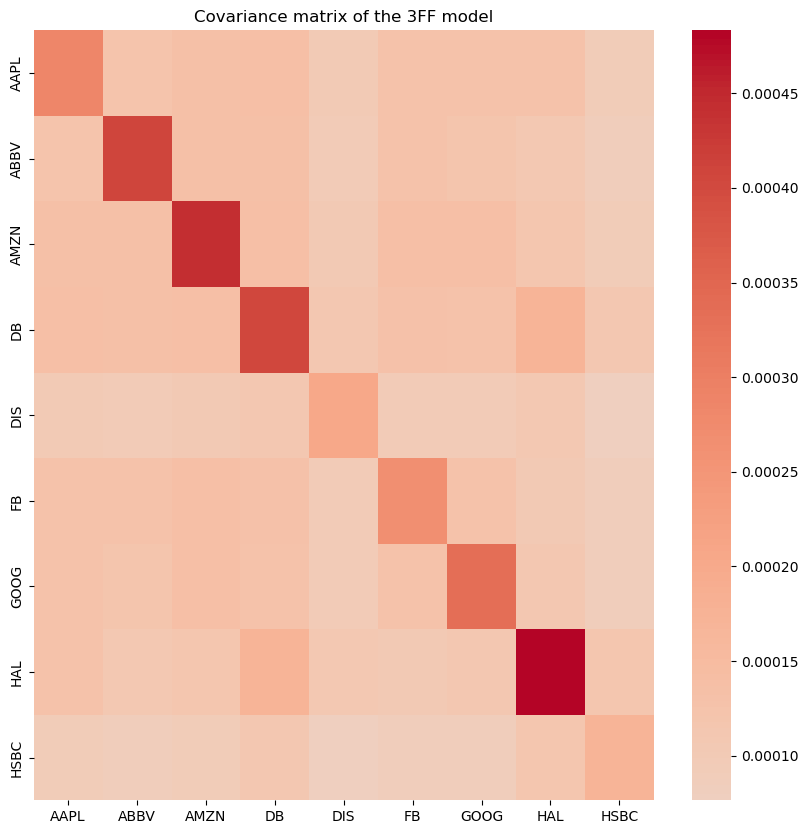

In [10]:
# create a matrix of the 3FF model matrix that contains a color scale. 

plt.figure(figsize=(10, 10))
sns.heatmap(Sigma_FamaFrench, cmap='coolwarm', center=0)
plt.title("Covariance matrix of the 3FF model")

Notably Haliburton seems to have the highest variance. In North America during 2015-2016, the oil and gas industry went through a historic cycle, punctuated by an almost 80 percent decline in the U.S. land rig count. Additionally, a Iranian nuclear deal was made in the same time frame, which led to reduced sanctions on Iranian and OPEC controlled oil. 

Text(0.5, 1.0, 'Correlation Matrix')

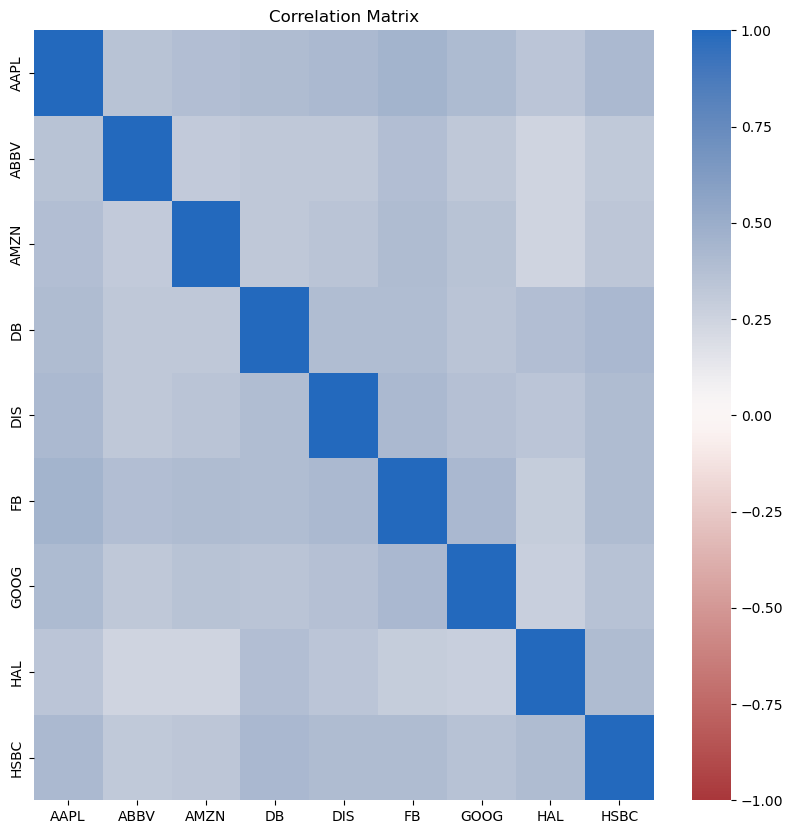

In [11]:


# plot the correlation matrix as a heatmap 
plt.figure(figsize=(10, 10))
sns.heatmap(cov2cor(Sigma_FamaFrench), cmap='vlag_r', robust=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix")

There is no super significant correlations between the 3FF model matrix. However, Apple seems to have relatively more correlation with all of the other stocks. This could be due to the increase in corporate partnerships and increased velocity of new product releases from APPL over the time frame. 

<Figure size 1000x800 with 0 Axes>

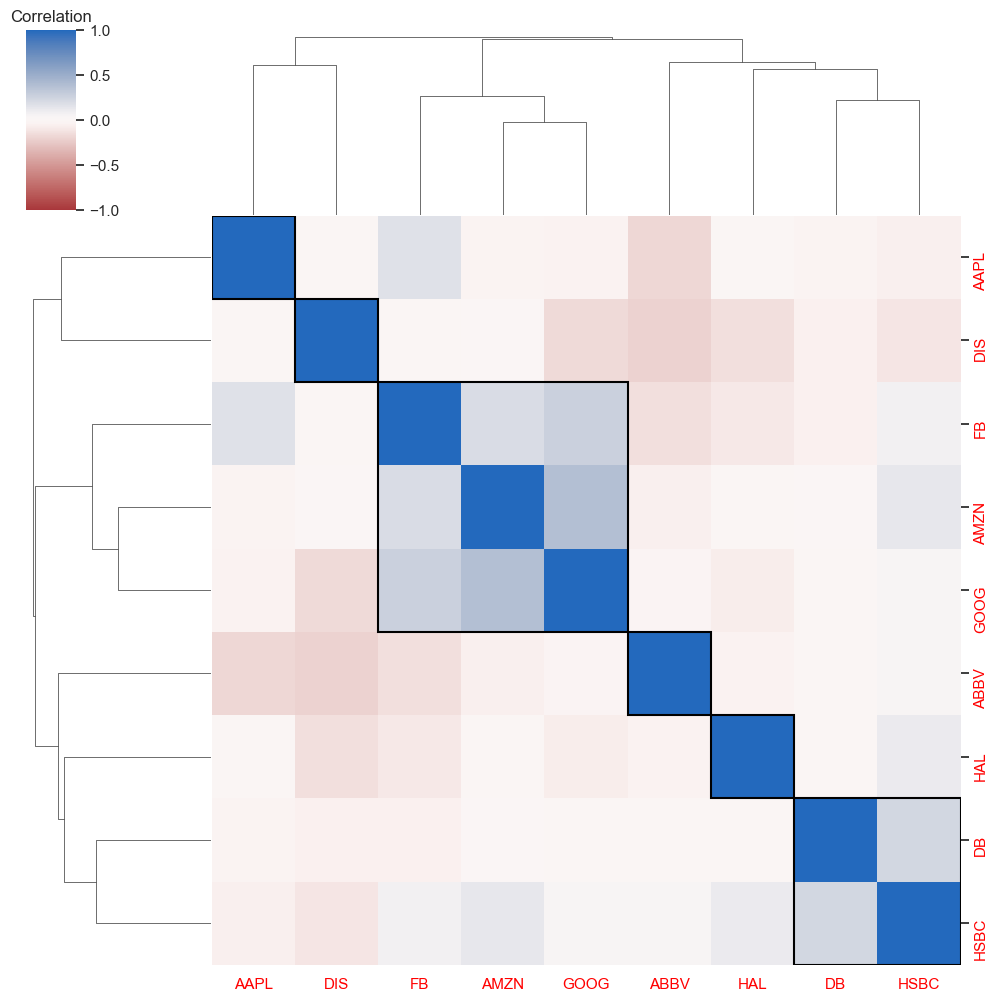

In [12]:
Psi = PsiFF

numclust = 6 #5 #3
# reduce figure size 
plt.figure(figsize=(10, 8))
clusterplot(Psi, numclust)

The cluster of FB AMZN and GOOG seems to have the highest correlation. This follows industry trends such as the Jim Cramer termed FAANG index. Duetsche Bank and HSBC are also highly correlated and makes sense as they are both banks. Cluster plot for PSI of the 3-factor model. PSI is the variance covariance matrix of residuals, where higher values indicate more unexplained volatility.

### Maximum Robust Ellipsoid (MRE) Analysis

Maximum robust ellipsoid (MRE) optimization is a method for finding the ellipsoid that contains the maximum number of points in a dataset. Using a varicance covariance matrix, the MRE can be used to find the ellipsoid that contains the maximum number of points in a dataset while optimizing for the minimum volume. The plane on which the data is contained is the eigenvector of the covariance matrix. The eigenvector with the largest eigenvalue is the direction of the maximum variance. The eigenvector with the smallest eigenvalue is the direction of the minimum variance. 



### Kappa 0.95 
In the context of the porfolio maximum robust ellipsoid (MRE) optimization, the Kappa 0.95 is used to measure the tail risk of the portfolio. It acts as a sort of bounding box size of the ellipsoid function. The higher the Kappa the more freedom the MRE has to choose riskier stocks.

In [13]:
kappa = 0.95

mu = X.mean(axis=0)
GMRP_robust_3FF = portfolioMaxReturnRobustEllipsoid(mu, Sigma_FamaFrench, kappa)
GMRP_robust_3FF_df = pd.DataFrame(GMRP_robust_3FF)
GMRP_robust_3FF_df['stock'] = X_trn.columns
GMRP_robust_3FF_df.columns = ['w', 'stock']

# Plot the results
chart_095_1 = alt.Chart(GMRP_robust_3FF_df).mark_bar(color='blue').encode(
    x='stock:N',
    y='w:Q'
)


Here we try a robust noisy solution. This creates additional noisy versions of the 3FF matrix which are sampled from a normal distribution. This then is used to acquire more robust estimates of the MRE.

In [14]:
# Robust Noisy Solution
w_all_GMRP_robust_ellipsoid = np.expand_dims(GMRP_robust_3FF, axis=1)

np.random.seed(100)
for i in range(6):
    X_noisy = pd.DataFrame(np.random.multivariate_normal(mu, Sigma_FamaFrench, size=T))
    mu_noisy = X_noisy.mean(axis=0)
    Sigma_noisy = X_noisy.cov()
    if not is_pos_def(Sigma_noisy, 0.001):
      Sigma_noisy = cov_nearest(Sigma_noisy)
    w_GMRP_robust_ellipsoid_noisy = portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa)
    w_all_GMRP_robust_ellipsoid = np.concatenate((w_all_GMRP_robust_ellipsoid,
                                                   np.expand_dims(w_GMRP_robust_ellipsoid_noisy, axis=1)), axis=1)

w_all_GMRP_robust_ellipsoid = pd.DataFrame(w_all_GMRP_robust_ellipsoid)
w_all_GMRP_robust_ellipsoid["stock"] = X_trn.columns

long_w_all_GMRP_robust_ellipsoid = pd.melt(
    w_all_GMRP_robust_ellipsoid,
    id_vars=['stock'],
    var_name='run',
    value_name='weight') # melt the dataframe to long format

# this chart shows the portfolio weights by stock and noisy run
chart_095_2 = alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar(size=10, color='red').encode(
    x=alt.X('run:O', axis=None),
    y='weight:Q',
    column=alt.Column('stock:N', spacing=2)
).properties(width=125, title='Portfolilo weight by stock and noisy run')


# this chart shows the proportion of portfolio weight by stock
chart_095_3=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar().encode(
    x=alt.X('run:O', axis=None),
    y=alt.Y('weight:Q', title='% weight'),
    color='stock:N',
    order=alt.Order('stock', sort='ascending')
).properties(width=500, title='Proportion of portfolio weight by stock')

In [15]:
chart_095_1

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

The 3FF model recommends that we invest in HSBC and DIS the most heavily. This makes sense because there was still ongoing recovery from the financial crisis, and safer more stable companies that provided inherit value and consistent returns to the stockholder are more attractive to the shareholders. 

In [16]:
chart_095_2

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

The chart above shows the MRE ellipsoid for the 3FF model. The weights of the stocks are represented by the bar. We ran the MRE 7 times so there are 7 different weights

In [17]:
chart_095_3

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

Here Disney and HSBC again are most recomended by the MRE analysis of the 3FF model. This is because they are the most stable and have the least tail risk.

### Kappa 0.7

In [18]:
kappa = 0.7

mu = X.mean(axis=0)
GMRP_robust_3FF = portfolioMaxReturnRobustEllipsoid(mu, Sigma_FamaFrench, kappa)
GMRP_robust_3FF_df = pd.DataFrame(GMRP_robust_3FF)
GMRP_robust_3FF_df['stock'] = X_trn.columns
GMRP_robust_3FF_df.columns = ['w', 'stock']

# Plot the results
chart_07_1 = alt.Chart(GMRP_robust_3FF_df).mark_bar(color='blue').encode(
    x='stock:N',
    y='w:Q'
)


In [19]:
# Robust Noisy Solution
w_all_GMRP_robust_ellipsoid = np.expand_dims(GMRP_robust_3FF, axis=1)

np.random.seed(100)
for i in range(6):
    X_noisy = pd.DataFrame(np.random.multivariate_normal(mu, Sigma_FamaFrench, size=T))
    mu_noisy = X_noisy.mean(axis=0)
    Sigma_noisy = X_noisy.cov()
    if not is_pos_def(Sigma_noisy, 0.001):
      Sigma_noisy = cov_nearest(Sigma_noisy)
    w_GMRP_robust_ellipsoid_noisy = portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa)
    w_all_GMRP_robust_ellipsoid = np.concatenate((w_all_GMRP_robust_ellipsoid,
                                                   np.expand_dims(w_GMRP_robust_ellipsoid_noisy, axis=1)), axis=1)

w_all_GMRP_robust_ellipsoid = pd.DataFrame(w_all_GMRP_robust_ellipsoid)
w_all_GMRP_robust_ellipsoid["stock"] = X_trn.columns

long_w_all_GMRP_robust_ellipsoid = pd.melt(
    w_all_GMRP_robust_ellipsoid,
    id_vars=['stock'],
    var_name='run',
    value_name='weight') # melt the dataframe to long format

# this chart shows the portfolio weights by stock and noisy run
chart_07_2 = alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar(size=10, color='red').encode(
    x=alt.X('run:O', axis=None),
    y='weight:Q',
    column=alt.Column('stock:N', spacing=2)
).properties(width=125, title='Portfolilo weight by stock and noisy run')


# this chart shows the proportion of portfolio weight by stock
chart_07_3=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar().encode(
    x=alt.X('run:O', axis=None),
    y=alt.Y('weight:Q', title='% weight'),
    color='stock:N',
    order=alt.Order('stock', sort='ascending')
).properties(width=500, title='Proportion of portfolio weight by stock')

In [20]:
chart_07_1

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [21]:
chart_07_2

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [22]:
chart_07_3

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

As the ellipsoid gets smaller, the model becomes more conservative and selects a majority of the 3 major companies previous mentioned. This is because the smaller the ellipsoid, the less risk the model is willing to take.HSBC, DIS, and FB. 

### Kappa 0.35

In [23]:
kappa = 0.35

mu = X.mean(axis=0)
GMRP_robust_3FF = portfolioMaxReturnRobustEllipsoid(mu, Sigma_FamaFrench, kappa)
GMRP_robust_3FF_df = pd.DataFrame(GMRP_robust_3FF)
GMRP_robust_3FF_df['stock'] = X_trn.columns
GMRP_robust_3FF_df.columns = ['w', 'stock']

# Plot the results
chart_035_1 = alt.Chart(GMRP_robust_3FF_df).mark_bar(color='blue').encode(
    x='stock:N',
    y='w:Q'
)


In [24]:
# Robust Noisy Solution
w_all_GMRP_robust_ellipsoid = np.expand_dims(GMRP_robust_3FF, axis=1)

np.random.seed(100)
for i in range(6):
    X_noisy = pd.DataFrame(np.random.multivariate_normal(mu, Sigma_FamaFrench, size=T))
    mu_noisy = X_noisy.mean(axis=0)
    Sigma_noisy = X_noisy.cov()
    if not is_pos_def(Sigma_noisy, 0.001):
      Sigma_noisy = cov_nearest(Sigma_noisy)
    w_GMRP_robust_ellipsoid_noisy = portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa)
    w_all_GMRP_robust_ellipsoid = np.concatenate((w_all_GMRP_robust_ellipsoid,
                                                   np.expand_dims(w_GMRP_robust_ellipsoid_noisy, axis=1)), axis=1)

w_all_GMRP_robust_ellipsoid = pd.DataFrame(w_all_GMRP_robust_ellipsoid)
w_all_GMRP_robust_ellipsoid["stock"] = X_trn.columns

long_w_all_GMRP_robust_ellipsoid = pd.melt(
    w_all_GMRP_robust_ellipsoid,
    id_vars=['stock'],
    var_name='run',
    value_name='weight') # melt the dataframe to long format

# this chart shows the portfolio weights by stock and noisy run
chart_035_2 = alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar(size=10, color='red').encode(
    x=alt.X('concat(stock, " - ", run):O', axis=alt.Axis(title='Stock - Run'), sort=None),
    y='weight:Q',
    column=alt.Column('stock:N', spacing=2)
).properties(width=125, title='Portfolilo weight by stock and noisy run')


# this chart shows the proportion of portfolio weight by stock
chart_035_3=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar().encode(
    x=alt.X('run:O', axis=None),
    y=alt.Y('weight:Q', title='% weight'),
    color='stock:N',
    order=alt.Order('stock', sort='ascending')
).properties(width=500, title='Proportion of portfolio weight by stock')

In [25]:
chart_035_1

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [26]:
chart_035_2

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [27]:
chart_035_3

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

Interestingly at 0.35 the model selects AMZN more than other stocks which was previously unidentified. Because the lower Kappa demands higher robustness, the model may be selecting more diversified activity from AMZN than in lower robustness models. This may include the 3FF factors, size, value, and market risk. Additionally, AMZN showed low overall correlation with other stocks and high variance which indicates strong independent robustness for the stock. 

# Sentiment indicator PNlog factor model

In [28]:
# Use Sentiment index for training
F_PNlog_trn = SentIndx.iloc[0:T_trn].to_frame()  # Convert series to dataframe

# Add a constant column to the factors for the intercept term
F_PNlog_trn.insert(0, 'ones', 1)

# Fit the model: X_trn ~ alpha + beta * SentIndx
Gamma_PNlog = pd.DataFrame(solve(F_PNlog_trn.T @ F_PNlog_trn, F_PNlog_trn.T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta"])
alpha_PNlog = Gamma_PNlog["alpha"]
B_PNlog = Gamma_PNlog[["beta"]]
E_PNlog = pd.DataFrame((X_trn.T - Gamma_PNlog.to_numpy() @ F_PNlog_trn.to_numpy().T).T, index=X_trn.index)
Psi_PNlog = (E_PNlog.T @ E_PNlog) / (T_trn - 2)


In [29]:
# Ensure F_PNlog_trn only includes the factors for the sentiment model (including the intercept)
F_PNlog_trn = F_PNlog_trn.drop(columns=['ones'])  

# Compute the covariance matrix of the factor returns
cov_factors = F_PNlog_trn.cov()

# Compute Sigma_PNlog
Sigma_PNlog = B_PNlog.to_numpy() @ cov_factors.to_numpy() @ B_PNlog.to_numpy().T + np.diag(np.diag(Psi_PNlog))


## K=0.95

In [30]:
kappa = 0.95

mu = X.mean(axis=0)
GMRP_robust_PNlog = portfolioMaxReturnRobustEllipsoid(mu, Sigma_PNlog, kappa)
GMRP_robust_PNlog_df = pd.DataFrame(GMRP_robust_PNlog)
GMRP_robust_PNlog_df['stock'] = X_trn.columns
GMRP_robust_PNlog_df.columns = ['w', 'stock']

# Plot the results
chart_095_1 = alt.Chart(GMRP_robust_PNlog_df).mark_bar(color='blue').encode(
    x='stock:N',
    y='w:Q'
).properties(
    title='kappa=0.95'
)


In [31]:
chart_095_1

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [32]:
# Robust Noisy Solution
w_all_GMRP_robust_ellipsoid = np.expand_dims(GMRP_robust_PNlog, axis=1)

np.random.seed(100)
for i in range(6):
    X_noisy = pd.DataFrame(np.random.multivariate_normal(mu, Sigma_PNlog, size=T))
    mu_noisy = X_noisy.mean(axis=0)
    Sigma_noisy = X_noisy.cov()
    if not is_pos_def(Sigma_noisy, 0.001):
      Sigma_noisy = cov_nearest(Sigma_noisy)
    w_GMRP_robust_ellipsoid_noisy = portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa)
    w_all_GMRP_robust_ellipsoid = np.concatenate((w_all_GMRP_robust_ellipsoid,
                                                   np.expand_dims(w_GMRP_robust_ellipsoid_noisy, axis=1)), axis=1)

w_all_GMRP_robust_ellipsoid = pd.DataFrame(w_all_GMRP_robust_ellipsoid)
w_all_GMRP_robust_ellipsoid["stock"] = X_trn.columns

long_w_all_GMRP_robust_ellipsoid = pd.melt(
    w_all_GMRP_robust_ellipsoid,
    id_vars=['stock'],
    var_name='run',
    value_name='weight')

chart_095_2 = alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar(size=10, color='red').encode(
    x=alt.X('run:O', axis=None),
    y='weight:Q',
    column=alt.Column('stock:N', spacing=2)
).properties(width=125, title='Portfolilo weight by stock and noisy run')

In [33]:
chart_095_2

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [34]:
chart_095_3=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar().encode(
    x=alt.X('run:O', axis=alt.Axis(title='Run Index', labels=True)), 
    y=alt.Y('weight:Q', title='% Weight', sort='ascending'),
    color=alt.Color('stock:N', scale=alt.Scale(scheme='tableau20'), legend=alt.Legend(title="Stock")),
    tooltip=[alt.Tooltip('run:N'), alt.Tooltip('stock:N'), alt.Tooltip('weight:Q')]
).properties(
    width=500, 
    title='kappa=0.95'
)

In [35]:
chart_095_3

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

## K=0.7

In [36]:
kappa = 0.7

GMRP_robust_PNlog = portfolioMaxReturnRobustEllipsoid(mu, Sigma_PNlog, kappa)
GMRP_robust_PNlog_df = pd.DataFrame(GMRP_robust_PNlog)
GMRP_robust_PNlog_df['stock'] = X_trn.columns
GMRP_robust_PNlog_df.columns = ['w', 'stock']

chart_07_1 = alt.Chart(GMRP_robust_PNlog_df).mark_bar(color='blue').encode(
    x='stock:N',
    y='w:Q'
).properties(
    title='kappa=0.7'  
)

In [37]:
# Robust Noisy Solution
w_all_GMRP_robust_ellipsoid = np.expand_dims(GMRP_robust_PNlog, axis=1)

np.random.seed(100)
for i in range(6):
    X_noisy = pd.DataFrame(np.random.multivariate_normal(mu, Sigma_PNlog, size=T))
    mu_noisy = X_noisy.mean(axis=0)
    Sigma_noisy = X_noisy.cov()
    if not is_pos_def(Sigma_noisy, 0.001):
      Sigma_noisy = cov_nearest(Sigma_noisy)
    w_GMRP_robust_ellipsoid_noisy = portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa)
    w_all_GMRP_robust_ellipsoid = np.concatenate((w_all_GMRP_robust_ellipsoid,
                                                   np.expand_dims(w_GMRP_robust_ellipsoid_noisy, axis=1)), axis=1)

w_all_GMRP_robust_ellipsoid = pd.DataFrame(w_all_GMRP_robust_ellipsoid)
w_all_GMRP_robust_ellipsoid["stock"] = X_trn.columns

long_w_all_GMRP_robust_ellipsoid = pd.melt(
    w_all_GMRP_robust_ellipsoid,
    id_vars=['stock'],
    var_name='run',
    value_name='weight')

chart_07_2=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar(size=10, color='red').encode(
    x=alt.X('run:O', axis=None),
    y='weight:Q',
    column=alt.Column('stock:N', spacing=2)
).properties(width=125, title='Portfolilo weight by stock and noisy run')

In [38]:
chart_07_3=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar().encode(
    x=alt.X('run:O', axis=alt.Axis(title='Run Index', labels=True)), 
    y=alt.Y('weight:Q', title='% Weight', sort='ascending'),
    color=alt.Color('stock:N', scale=alt.Scale(scheme='tableau20'), legend=alt.Legend(title="Stock")),
    tooltip=[alt.Tooltip('run:N'), alt.Tooltip('stock:N'), alt.Tooltip('weight:Q')]
).properties(
    width=500, 
    title='kappa=0.7'
)

## K=0.35

In [39]:
kappa = 0.35

GMRP_robust_PNlog = portfolioMaxReturnRobustEllipsoid(mu, Sigma_PNlog, kappa)
GMRP_robust_PNlog_df = pd.DataFrame(GMRP_robust_PNlog)
GMRP_robust_PNlog_df['stock'] = X_trn.columns
GMRP_robust_PNlog_df.columns = ['w', 'stock']

# Plot the results
chart_035_1=alt.Chart(GMRP_robust_PNlog_df).mark_bar(color='blue').encode(
    x='stock:N',
    y='w:Q'
).properties(
    title='kappa=0.35'
)

In [40]:
# Robust Noisy Solution
w_all_GMRP_robust_ellipsoid = np.expand_dims(GMRP_robust_PNlog, axis=1)

np.random.seed(100)
for i in range(6):
    X_noisy = pd.DataFrame(np.random.multivariate_normal(mu, Sigma_PNlog, size=T))
    mu_noisy = X_noisy.mean(axis=0)
    Sigma_noisy = X_noisy.cov()
    if not is_pos_def(Sigma_noisy, 0.001):
      Sigma_noisy = cov_nearest(Sigma_noisy)
    w_GMRP_robust_ellipsoid_noisy = portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa)
    w_all_GMRP_robust_ellipsoid = np.concatenate((w_all_GMRP_robust_ellipsoid,
                                                   np.expand_dims(w_GMRP_robust_ellipsoid_noisy, axis=1)), axis=1)

w_all_GMRP_robust_ellipsoid = pd.DataFrame(w_all_GMRP_robust_ellipsoid)
w_all_GMRP_robust_ellipsoid["stock"] = X_trn.columns

long_w_all_GMRP_robust_ellipsoid = pd.melt(
    w_all_GMRP_robust_ellipsoid,
    id_vars=['stock'],
    var_name='run',
    value_name='weight')

chart_035_2=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar(size=10, color='red').encode(
    x=alt.X('run:O', axis=None),
    y='weight:Q',
    column=alt.Column('stock:N', spacing=2)
).properties(width=125, title='Portfolilo weight by stock and noisy run')

In [41]:
chart_035_3=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar().encode(
    x=alt.X('run:O', axis=alt.Axis(title='Run Index', labels=True)), 
    y=alt.Y('weight:Q', title='% Weight', sort='ascending'),
    color=alt.Color('stock:N', scale=alt.Scale(scheme='tableau20'), legend=alt.Legend(title="Stock")),
    tooltip=[alt.Tooltip('run:N'), alt.Tooltip('stock:N'), alt.Tooltip('weight:Q')]
).properties(
    width=500, 
    title='kappa=0.35'
)

## K=0.1

In [42]:
kappa = 0.1

GMRP_robust_PNlog = portfolioMaxReturnRobustEllipsoid(mu, Sigma_PNlog, kappa)
GMRP_robust_PNlog_df = pd.DataFrame(GMRP_robust_PNlog)
GMRP_robust_PNlog_df['stock'] = X_trn.columns
GMRP_robust_PNlog_df.columns = ['w', 'stock']

# Plot the results
chart_01_1=alt.Chart(GMRP_robust_PNlog_df).mark_bar(color='blue').encode(
    x='stock:N',
    y='w:Q'
).properties(
    title='kappa=0.1'
)

In [43]:
# Robust Noisy Solution
w_all_GMRP_robust_ellipsoid = np.expand_dims(GMRP_robust_PNlog, axis=1)

np.random.seed(100)
for i in range(6):
    X_noisy = pd.DataFrame(np.random.multivariate_normal(mu, Sigma_PNlog, size=T))
    mu_noisy = X_noisy.mean(axis=0)
    Sigma_noisy = X_noisy.cov()
    if not is_pos_def(Sigma_noisy, 0.001):
      Sigma_noisy = cov_nearest(Sigma_noisy)
    w_GMRP_robust_ellipsoid_noisy = portfolioMaxReturnRobustEllipsoid(mu_noisy, Sigma_noisy, kappa)
    w_all_GMRP_robust_ellipsoid = np.concatenate((w_all_GMRP_robust_ellipsoid,
                                                   np.expand_dims(w_GMRP_robust_ellipsoid_noisy, axis=1)), axis=1)

w_all_GMRP_robust_ellipsoid = pd.DataFrame(w_all_GMRP_robust_ellipsoid)
w_all_GMRP_robust_ellipsoid["stock"] = X_trn.columns

long_w_all_GMRP_robust_ellipsoid = pd.melt(
    w_all_GMRP_robust_ellipsoid,
    id_vars=['stock'],
    var_name='run',
    value_name='weight')

chart_01_2=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar(size=10, color='red').encode(
    x=alt.X('run:O', axis=None),
    y='weight:Q',
    column=alt.Column('stock:N', spacing=2)
).properties(width=125, title='Portfolilo weight by stock and noisy run')

In [44]:
chart_01_3=alt.Chart(long_w_all_GMRP_robust_ellipsoid).mark_bar().encode(
    x=alt.X('run:O', axis=alt.Axis(title='Run Index', labels=True)), 
    y=alt.Y('weight:Q', title='% Weight', sort='ascending'),
    color=alt.Color('stock:N', scale=alt.Scale(scheme='tableau20'), legend=alt.Legend(title="Stock")),
    tooltip=[alt.Tooltip('run:N'), alt.Tooltip('stock:N'), alt.Tooltip('weight:Q')]
).properties(
    width=500, 
    title='kappa=0.1'
)

In [45]:
chart_01_3

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

## Visualization and comparison

In [46]:
combined_chart_1 = alt.hconcat(chart_095_1, chart_07_1, chart_035_1, chart_01_1)
combined_chart_1 = combined_chart_1.properties(
    title="Portfolio Weights for Different Kappas"
)
combined_chart_1


/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/c

alt.HConcatChart(...)

In [47]:
# Horizontal combination of the first two charts
top_row_2 = alt.hconcat(chart_095_2, chart_07_2)

# Horizontal combination of the second two charts
bottom_row_2 = alt.hconcat(chart_035_2, chart_01_2)

# Vertical combination of the two rows
combined_chart_2 = alt.vconcat(top_row_2, bottom_row_2)

# Display the combined chart
combined_chart_2

/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/c

alt.VConcatChart(...)

In [48]:
import altair as alt

# Assuming chart_095_3, chart_07_3, chart_035_3, chart_01_3 are previously defined Altair chart objects

# Horizontal combination of the first two charts for the top row
top_row_3 = alt.hconcat(chart_095_3, chart_07_3)

# Horizontal combination of the second two charts for the bottom row
bottom_row_3 = alt.hconcat(chart_035_3, chart_01_3)

# Vertical combination of the two rows
combined_chart_3 = alt.vconcat(top_row_3, bottom_row_3)

# Adding a title to the combined chart
final_chart = combined_chart_3.properties(
    title="Proportion of Portfolio Weight by Stock for different kappas with multiple noise"
)

# Display the combined chart with the title
final_chart


/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.11/site-packages/altair/utils/c

alt.VConcatChart(...)